<a href="https://colab.research.google.com/github/estnafinema0/Yandex-SHAD-ML-Handbook/blob/main/hw_fmnist_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Переобучение нейронных сетей и борьба с ним

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/girafe_ai

In [ ]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")

        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [ ]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-20 21:52:47--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-20 21:52:47--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1 (уже решённая): Создание и обучение модели (Separation)
Вы уже решали эту задачу ранее, так что сейчас просто воспроизведите своё решение. Оно понадобится вам в дальнейших шагах.
__Ваша первая задача всё та же: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__


In [ ]:
CUDA_DEVICE_ID = 0  # change if needed

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 196kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.93MB/s]


Text(0.5, 1.0, 'Image label: 2')

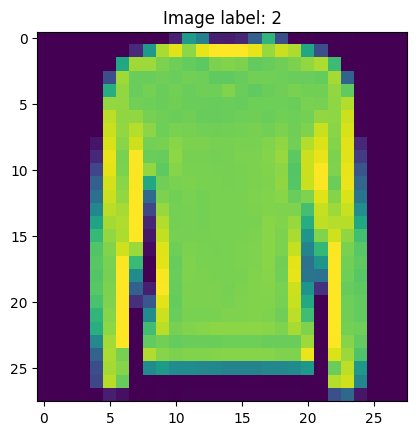

In [ ]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [ ]:
# Creating model instance
class ClassifierMNIST(nn.Module):
  def __init__(self):
    super(ClassifierMNIST, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

model_task_1 = ClassifierMNIST()

Не забудьте перенести модель на выбранный `device`!

In [ ]:
model_task_1.to(device)

ClassifierMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model_task_1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epoch = 8
for epoch in range(num_epoch):
  model_task_1.train()
  running_loss = 0.0
  for images, labels in train_data_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model_task_1(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  avg_loss = running_loss / len(train_data_loader)
  train_acc = get_accuracy(model_task_1, train_data_loader)
  test_acc = get_accuracy(model_task_1, test_data_loader)
  print(f"Epoch {epoch+1}/{num_epoch}, Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/8, Loss: 0.4231, Train Acc: 0.8952, Test Acc: 0.8845
Epoch 2/8, Loss: 0.2702, Train Acc: 0.9134, Test Acc: 0.8994
Epoch 3/8, Loss: 0.2268, Train Acc: 0.9332, Test Acc: 0.9086
Epoch 4/8, Loss: 0.1919, Train Acc: 0.9384, Test Acc: 0.9137
Epoch 5/8, Loss: 0.1678, Train Acc: 0.9516, Test Acc: 0.9177
Epoch 6/8, Loss: 0.1431, Train Acc: 0.9572, Test Acc: 0.9143
Epoch 7/8, Loss: 0.1219, Train Acc: 0.9655, Test Acc: 0.9203
Epoch 8/8, Loss: 0.1044, Train Acc: 0.9749, Test Acc: 0.9219


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [ ]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.97487


In [ ]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9219


Проверка, что необходимые пороги пройдены:

In [ ]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче.

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [ ]:
# Creating model instance
class ClassifierMNISTOverfit(nn.Module):
  def __init__(self):
    super(ClassifierMNISTOverfit, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1   = nn.Linear(256, 512)
    self.fc2   = nn.Linear(512, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)  # 64×14×14
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)  # 128×7×7
    x = self.conv3(x)
    x = self.relu(x)
    x = self.pool(x)  # 256×3×3
    x = self.conv4(x)
    x = self.relu(x)
    x = self.pool(x)  # 512×1×1
    x = x.view(x.size(0), -1)             # B×512
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


model_task_2 = ClassifierMNISTOverfit().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_task_2.parameters(), lr=1e-3)

num_epochs = 15
for epoch in range(num_epochs):
    model_task_2.train()
    total_loss = 0.0
    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_task_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_acc = get_accuracy(model_task_2, train_data_loader)
    test_acc  = get_accuracy(model_task_2, test_data_loader)
    print(f"Epoch {epoch:02d}: Loss={total_loss/len(train_data_loader):.4f}  "
          f"Train Acc={train_acc:.4f}  Test Acc={test_acc:.4f}")

final_train_acc = get_accuracy(model_task_2, train_data_loader)
final_test_acc  = get_accuracy(model_task_2, test_data_loader)
print(f"\n>>> Final: Train Accuracy = {final_train_acc:.4f},  Test Accuracy = {final_test_acc:.4f}")

Epoch 00: Loss=0.4732  Train Acc=0.8880  Test Acc=0.8800
Epoch 01: Loss=0.2872  Train Acc=0.9166  Test Acc=0.9013
Epoch 02: Loss=0.2382  Train Acc=0.9285  Test Acc=0.9080
Epoch 03: Loss=0.2077  Train Acc=0.9408  Test Acc=0.9175
Epoch 04: Loss=0.1842  Train Acc=0.9337  Test Acc=0.9093
Epoch 05: Loss=0.1620  Train Acc=0.9520  Test Acc=0.9163
Epoch 06: Loss=0.1431  Train Acc=0.9593  Test Acc=0.9203
Epoch 07: Loss=0.1278  Train Acc=0.9633  Test Acc=0.9180
Epoch 08: Loss=0.1130  Train Acc=0.9657  Test Acc=0.9138
Epoch 09: Loss=0.1017  Train Acc=0.9682  Test Acc=0.9155
Epoch 10: Loss=0.0912  Train Acc=0.9715  Test Acc=0.9171
Epoch 11: Loss=0.0836  Train Acc=0.9711  Test Acc=0.9156
Epoch 12: Loss=0.0745  Train Acc=0.9778  Test Acc=0.9175
Epoch 13: Loss=0.0698  Train Acc=0.9823  Test Acc=0.9165
Epoch 14: Loss=0.0644  Train Acc=0.9829  Test Acc=0.9163

>>> Final: Train Accuracy = 0.9829,  Test Accuracy = 0.9163


Проверка архитектуры:

In [ ]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Оценим качество классификации:

In [ ]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.98295


In [ ]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.9163


Проверка, что переобучение присутствует:

In [ ]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return)
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче.

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [ ]:
# Creating model instance
class ClassifierMNISTOverfitOvercome(nn.Module):
    def __init__(self):
      super(ClassifierMNISTOverfitOvercome, self).__init__()
      self.conv1 = nn.Conv2d(1,   64, kernel_size=3, padding=1)
      self.bn1   = nn.BatchNorm2d(64)
      self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
      self.bn2   = nn.BatchNorm2d(128)
      self.conv3 = nn.Conv2d(128,256, kernel_size=3, padding=1)
      self.bn3   = nn.BatchNorm2d(256)
      self.pool  = nn.MaxPool2d(2, 2)
      self.fc1   = nn.Linear(2304, 128)
      self.dropout = nn.Dropout(0.5)
      self.fc2   = nn.Linear(128, 10)
      self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)
        return x


model_task_3 = ClassifierMNISTOverfitOvercome().to(device)

Проверка архитектуры:

In [ ]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

In [ ]:
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model_task_3.parameters(), lr=5e-4, weight_decay=1e-3)

num_epochs = 12
for epoch in range(num_epochs):
    model_task_3.train()
    running_loss = 0.0
    for imgs, labs in train_data_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        out = model_task_3(imgs)
        loss = criterion(out, labs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_acc = get_accuracy(model_task_3, train_data_loader)
    test_acc  = get_accuracy(model_task_3, test_data_loader)
    diff = train_acc - test_acc
    print(f"Epoch {epoch:02d}: Loss={running_loss/len(train_data_loader):.4f}  "
          f"Train Acc={train_acc:.4f}  Test Acc={test_acc:.4f}  Δ={diff:.4f}")

final_train = get_accuracy(model_task_3, train_data_loader)
final_test  = get_accuracy(model_task_3, test_data_loader)
print(f"\n>>> Final: Train Acc = {final_train:.4f}, Test Acc = {final_test:.4f}, Δ = {final_train - final_test:.4f}")

Epoch 00: Loss=0.7133  Train Acc=0.8551  Test Acc=0.8459  Δ=0.0092
Epoch 01: Loss=0.4873  Train Acc=0.8691  Test Acc=0.8576  Δ=0.0115
Epoch 02: Loss=0.4361  Train Acc=0.8813  Test Acc=0.8694  Δ=0.0119
Epoch 03: Loss=0.4084  Train Acc=0.8951  Test Acc=0.8874  Δ=0.0077
Epoch 04: Loss=0.3887  Train Acc=0.9030  Test Acc=0.8924  Δ=0.0106
Epoch 05: Loss=0.3754  Train Acc=0.8978  Test Acc=0.8884  Δ=0.0094
Epoch 06: Loss=0.3619  Train Acc=0.8921  Test Acc=0.8804  Δ=0.0117
Epoch 07: Loss=0.3532  Train Acc=0.8996  Test Acc=0.8875  Δ=0.0121
Epoch 08: Loss=0.3440  Train Acc=0.9093  Test Acc=0.8989  Δ=0.0104
Epoch 09: Loss=0.3399  Train Acc=0.9123  Test Acc=0.9030  Δ=0.0093
Epoch 10: Loss=0.3382  Train Acc=0.9080  Test Acc=0.8954  Δ=0.0126
Epoch 11: Loss=0.3325  Train Acc=0.8981  Test Acc=0.8880  Δ=0.0101

>>> Final: Train Acc = 0.8981, Test Acc = 0.8880, Δ = 0.0101


Оценим качество классификации:

In [ ]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.89812


In [ ]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.888


Проверка, что переобучение присутствует:

In [ ]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.


`submission_dict_task_1.json` сдавать не нужно, он уже был сдан ранее.

На этом задание завершено. Поздравляем!